<p style="background-color:#e6f7ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#d0eefc; 
          border-style:solid;
          border-radius:6px"> 🔍 In this projet we'll tackle a common NLP task: <code>Question Answering (QA)</code> which involves retrieving relevant documents and extracting answers from them, commonly through extractive QA, where the answer is identified as a span of text within a document. Modern QA systems, like those used in search engines and intelligent assistants, follow a two-stage process of document retrieval and answer extraction.
</p>



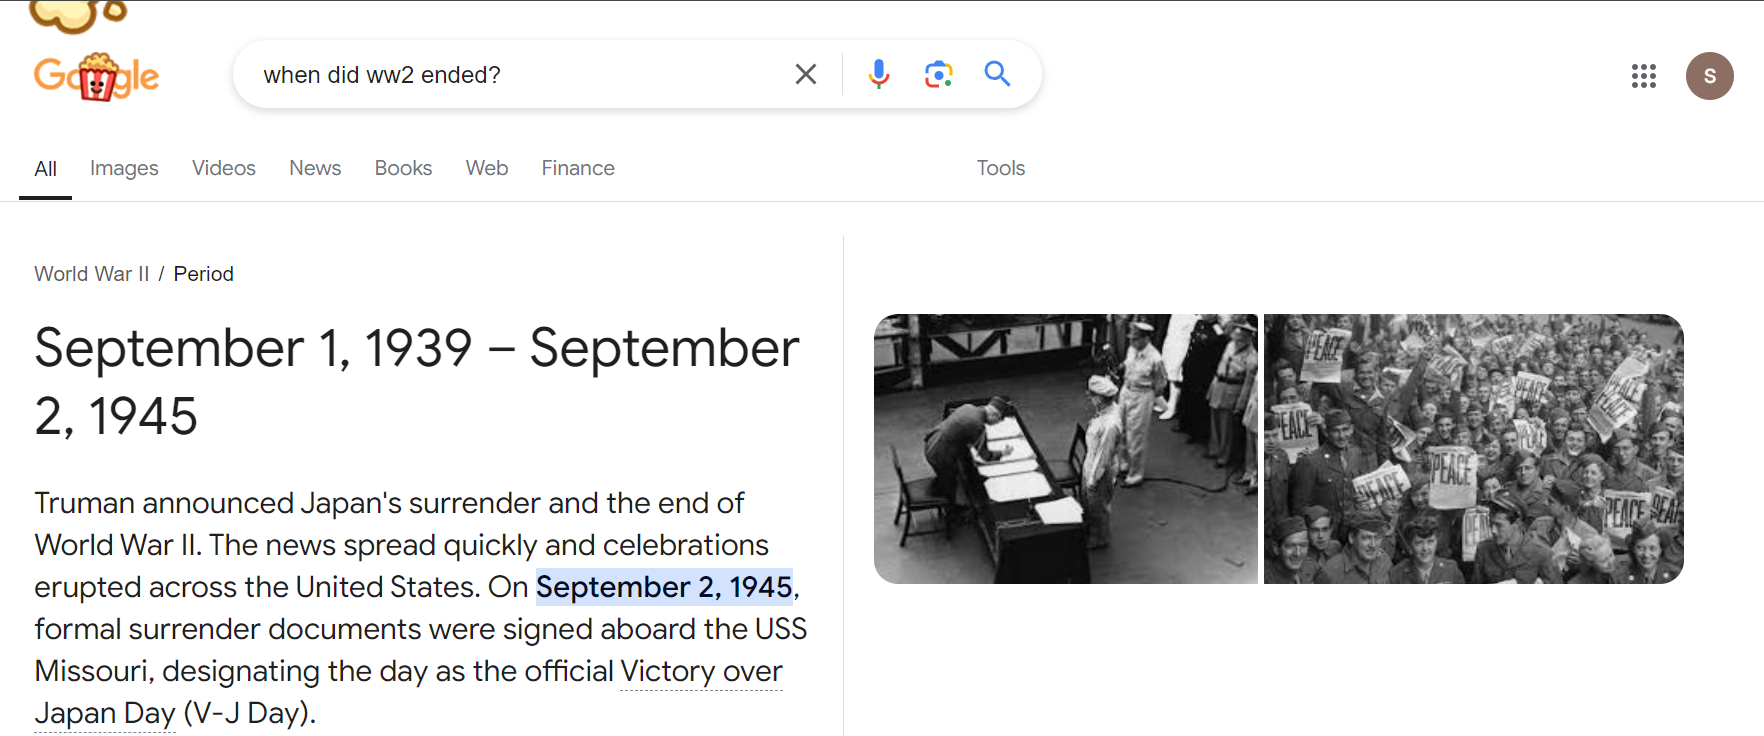

$$$$

### Setup

In [ ]:
# Haystack ElasticSearch
!pip install farm-haystack[elasticsearch] -q
!pip install farm-haystack[inference] -q
!pip install farm-haystack[metrics] -q
!pip install -U sentence-transformers -q

# Restart  Kernel
import os
print(f'Restarting Kernel ...')
os._exit(00)

In [1]:
from IPython.display import clear_output

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

$$$$

## Building a Review-Based QA System

### The Dataset

<p style="background-color:#ffe6f7; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#f5dce9; 
          border-style:solid;
          border-radius:6px"> 📄 We will use the <code>SubjQA</code> dataset, which contains over 10,000 customer reviews across six domains: <code>TripAdvisor</code>, <code>Restaurants</code>, <code>Movies</code>, <code>Books</code>, <code>Electronics</code>, and <code>Grocery</code>. Each review is paired with a question that can be answered using sentences from the review. </br>What makes this dataset unique is its focus on subjective questions and answers based on personal experiences. This makes SubjQA a realistic benchmark for review-based QA models, as it mirrors the complexity of real-world user-generated content.
</p>


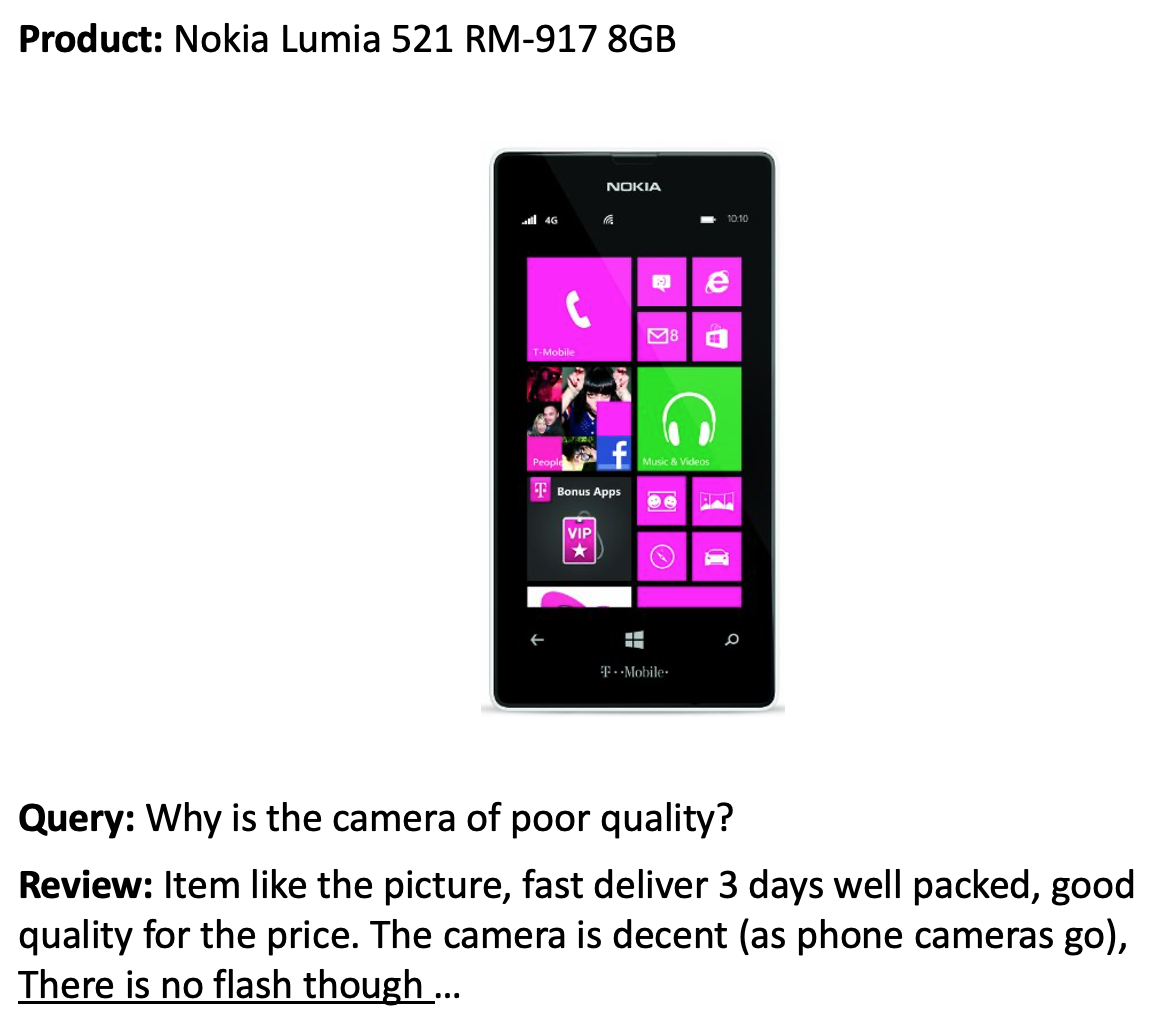

**Download Dataset**

In [2]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa", trust_remote_code=True)
domains

subjqa.py:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

<p style="background-color:#ffe6f7; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#f5dce9; 
          border-style:solid;
          border-radius:6px"> 📄 For our use case, we’ll focus on building a QA system for the <code>Electronics</code> domain.

</p>


In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics",trust_remote_code=True)
clear_output()

**Inspect some of the columns**

In [3]:
cols = ['domain', 'nn_mod', 'nn_asp', 'query_mod','query_asp','q_reviews_id',
 'question_subj_level','ques_subj_score','is_ques_subjective','review_id','id']

subjqa["train"].to_pandas().iloc[1][cols].to_frame()

,1
domain,electronics
nn_mod,harsh
nn_asp,high
query_mod,not strong
query_asp,bass
q_reviews_id,7c46670208f7bf5497480fbdbb44561a
question_subj_level,1
ques_subj_score,0.5
is_ques_subjective,False
review_id,ce76793f036494eabe07b33a9a67288a


**Inspect a question**

In [25]:
pd.set_option('display.max_colwidth', None)
cols = ['title','context','question','answers']

subjqa["train"].to_pandas().iloc[1][cols].to_frame()

,1
title,B00001P4ZH
context,"To anyone who hasn't tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they're good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they're very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn't find it as comfortable as many have claimed. Earpads are *very* thin and made my ears sore after 30 minutes of listening, although this can be remedied to a point by adjusting the ""comfort zone"" feature (tightening the temple pads while loosening the ear pads). The cord seems to be an average thickness, but I wouldn't get too rough with these. The steel headband adjusts smoothly and easily, just watch out that the slider doesn't catch your hair. Despite the sore ears, the phones are very lightweight overall.Back to the sound: as you would expect, it's good for a portable phone, but hardly earth shattering. At flat EQ the clarity is good, although the highs can sometimes be harsh. Bass is weak as expected, even with EQ adjusted up. To be fair, a portable on-ear would have a tough time comparing to the bass of an in-ear with a good seal or a pair with larger drivers. No sound isolation offered if you're into that sort of thing. Cool 80s phones, though I've certainly owned better portable on-ears (Sony makes excellent phones in this category). Soundstage is very narrow and lacks body. A good value if you can get them for under thirty, otherwise I'd rather invest in a nicer pair of phones. If we're talking about value, they're a good buy compared to new stock apple buds. If you're trying to compare the sound quality of this product to serious headphones, there's really no comparison at all.Update: After 100 hours of burn-in time the sound has not been affected in any appreciable way. Highs are still harsh, and bass is still underwhelming. I sometimes use these as a convenience but they have been largely replaced in my collection."
question,Is this music song have a goo bass?
answers,"{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333, 0.5083333], 'is_ans_subjective': [True, True]}"


**flatten the nested columns  and convert each split to a`Pandas`**:

In [3]:
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


**The most important columns in the dataset**

In [33]:
df_cols = pd.DataFrame()
df_cols['Column name'] = ['title','question','answers.answer_text',
                          'answers.answer_start','context']
df_cols['Description'] = ['The Amazon Standard Identification Number (ASIN) associated with each product',
                          'The question',
                          'The span of text in the review labeled by the annotator',
                          'The start character index of the answer span',
                          'context The customer review']
df_cols

,Column name,Description
0,title,The Amazon Standard Identification Number (ASIN) associated with each product
1,question,The question
2,answers.answer_text,The span of text in the review labeled by the annotator
3,answers.answer_start,The start character index of the answer span
4,context,context The customer review


In [32]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],"I really like this keyboard. I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on. But for the price, it really suffices as a wireless keyboard. I have very large hands and this keyboard is compact, but I have no complaints."
1159,B00AAIPT76,How is the battery?,[],[],"I bought this after the first spare gopro battery I bought wouldn't hold a charge. I have very realistic expectations of this sort of product, I am skeptical of amazing stories of charge time and battery life but I do expect the batteries to hold a charge for a couple of weeks at least and for the charger to work like a charger. In this I was not disappointed. I am a river rafter and found that the gopro burns through power in a hurry so this purchase solved that issue. the batteries held a charge, on shorter trips the extra two batteries were enough and on longer trips I could use my friends JOOS Orange to recharge them.I just bought a newtrent xtreme powerpak and expect to be able to charge these with that so I will not run out of power again."


**Determine the span of text in the review that corresponds to the answer based on the start index and len of the text**

In [37]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

**Types of questions in the training set**

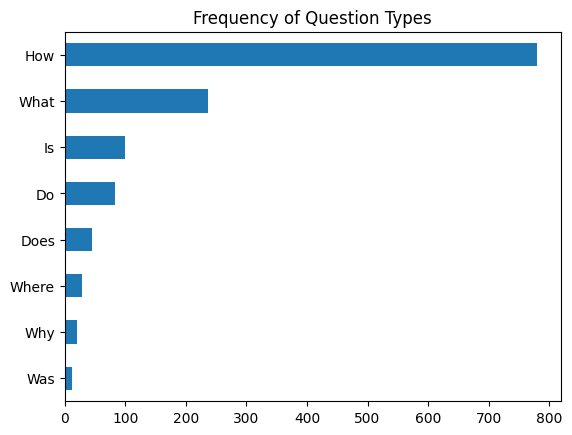

In [39]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

**some examples of questions**

In [40]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### Extracting Answers from Text

<div style="
    background-color: #fff6ff;
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #efe6ef;
    border-style: solid;
    border-radius: 6px;
            ">
  📚 To build our QA system, we need to extract answers from customer reviews by identifying them as spans of text. This task is framed as a <code>span classification</code> problem, where the model predicts the start and end tokens of the answer.<br>
    Key steps include:<br>
  <ul style="background-color: inherit; /* Use the parent background color */
    color: inherit; /* Use the parent text color */
    font-size: inherit; /* Use the parent font size */
    list-style-type: disc;
    margin-left: 20px;
    padding-left: 0;">
    <li>Frame the supervised learning problem</li>
    <li>Tokenize and encode text for QA tasks</li>
    <li>Deal with long passages that exceed a model’s maximum context size</li>
  </ul>
</div>


<p style='font-size:17px;font-weight:bold'>
    Span classification
</p>

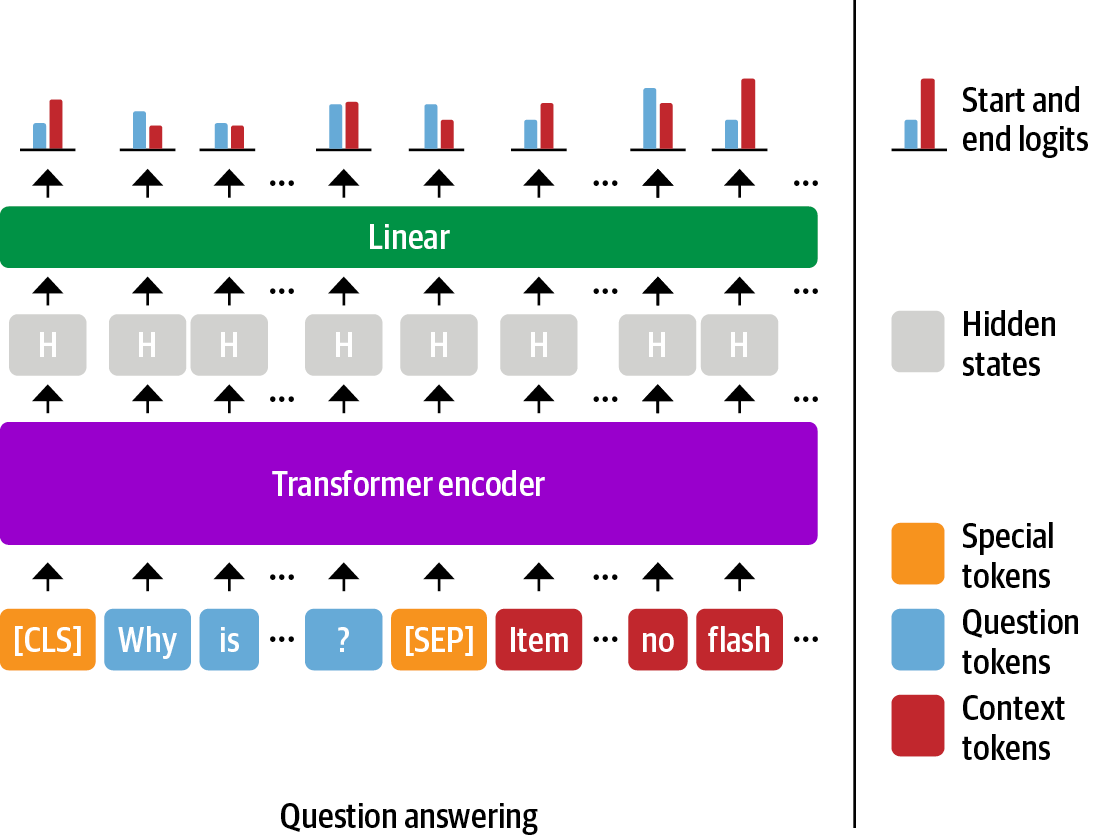

<p style='font-size:17px;font-weight:bold'>
Tokenizing text for QA
</p>

<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>
    In this project we’ll use a fine-tuned <code>MiniLM</code> model since it is fast to train and will allow us to
quickly iterate over various techniques.
</p>


In [4]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

**let's try it on an example**

In [9]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""

inputs = tokenizer(question, context, return_tensors="pt")

In [16]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


**How the tokenizer formats the inputs for `QA`**

<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>
    <code>[CLS]</code> question tokens <code>[SEP]</code> context tokens <code>[SEP]</code>
</p>


In [13]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

**Instantiate Model**

In [5]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt).to(device)

**Try model**

In [19]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [20]:
outputs.keys()

odict_keys(['start_logits', 'end_logits'])

In [22]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


**Start-End Token Logits bar plot**

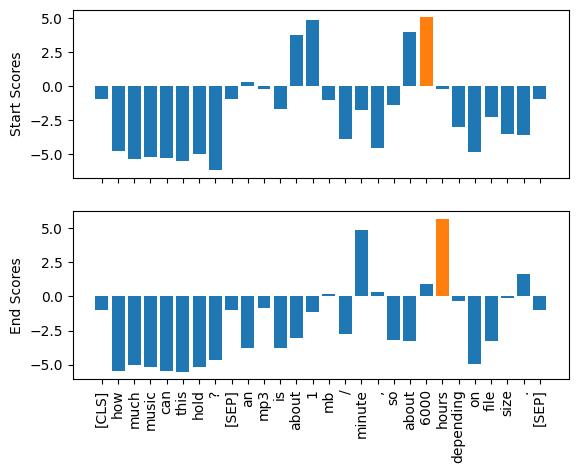

In [28]:
s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation='vertical')
plt.show()

**Decode Answer**

In [29]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


**Let's use the pipe**

In [6]:
from transformers import pipeline

pipe = pipeline("question-answering",
                model=model,
                tokenizer=tokenizer,
                device=device)

In [30]:
pipe(question=question, context=context, top_k=3)

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651616930961609, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082944214344025,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253512114286423,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

**Handle questions that give no answer**

In [31]:
pipe(question="Why is there no data?",
     context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

<p style='font-size:17px;font-weight:bold'>
Dealing with long passages
</p>

<div style="
    background-color: #e6ffe6; 
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #d9f5d9;
    border-style: solid;
    border-radius: 6px;
            ">
  📖 In <code>QA</code> systems, long passages often exceed the model's maximum token limit (e.g., 512 tokens for MiniLM), which can lead to truncation of important information. To handle this, instead of truncating the context like in text classification tasks, a <code>sliding window</code> approach is used. This method divides the long passage into overlapping segments, ensuring the entire context is processed while preserving potential answers located near the end.
</div>



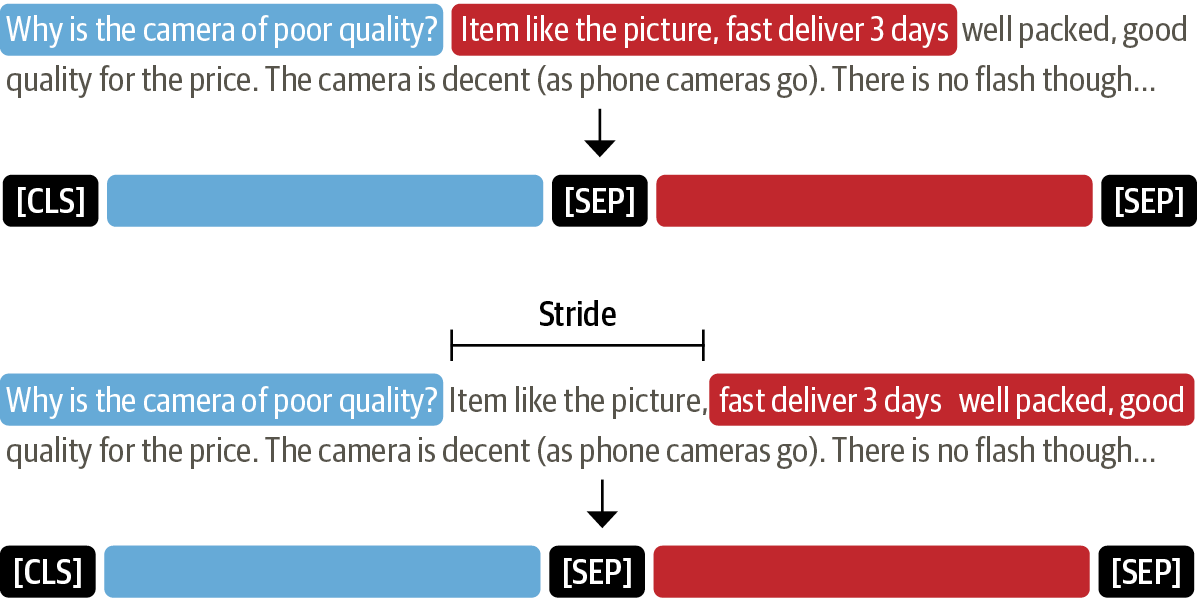

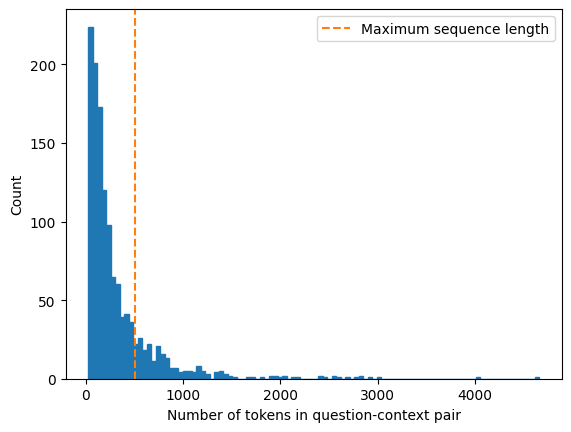

In [8]:
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

In [23]:
num_over_limit = dfs['train'][dfs["train"]["n_tokens"] > 512].shape[0]
print(f'N° examples in the train set: {dfs["train"].shape[0]}')
print(f'N° examples with tokens that exceeds the model max seq len: {num_over_limit}')

N° examples in the train set: 1295
N° examples that contains more tokens than the max sequence length of the model: 230


<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>
    In Transformers, setting <code>return_overflowing_tokens=True</code> enables the sliding window, with <code>max_seq_length</code> controlling the <code>window size</code> and <code>doc_stride</code> determining the <code>overlap</code> between segments.
</p>



In [26]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"],
                              example["context"],
                              return_overflowing_tokens=True,
                              max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


**In this case we now get a list of input_ids, one for each window.**

In [31]:
for idx, window in enumerate(tokenized_example["input_ids"]):
     print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


**we can see where two windows overlap by decoding the inputs**

In [39]:
for window in tokenized_example["input_ids"]:
     print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### Using Haystack to Build a QA Pipeline

<div style="
    background-color: #fff6e4; 
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #f5ecda;
    border-style: solid;
    border-radius: 6px;
            ">
  🤖 In our answer extraction example, we initially supplied both the question and context to the model. However, users will only provide product questions, necessitating a method to select relevant passages from all reviews. To efficiently handle this, modern <code>QA</code> systems use a <code>retriever-reader</code> architecture: the <code>retriever</code> identifies pertinent documents, while the <code>reader</code> extracts answers. We will utilize the <code>Haystack</code> library from <code>deepset</code>, which incorporates key components like a document store and a pipeline to streamline the QA process.
</div>




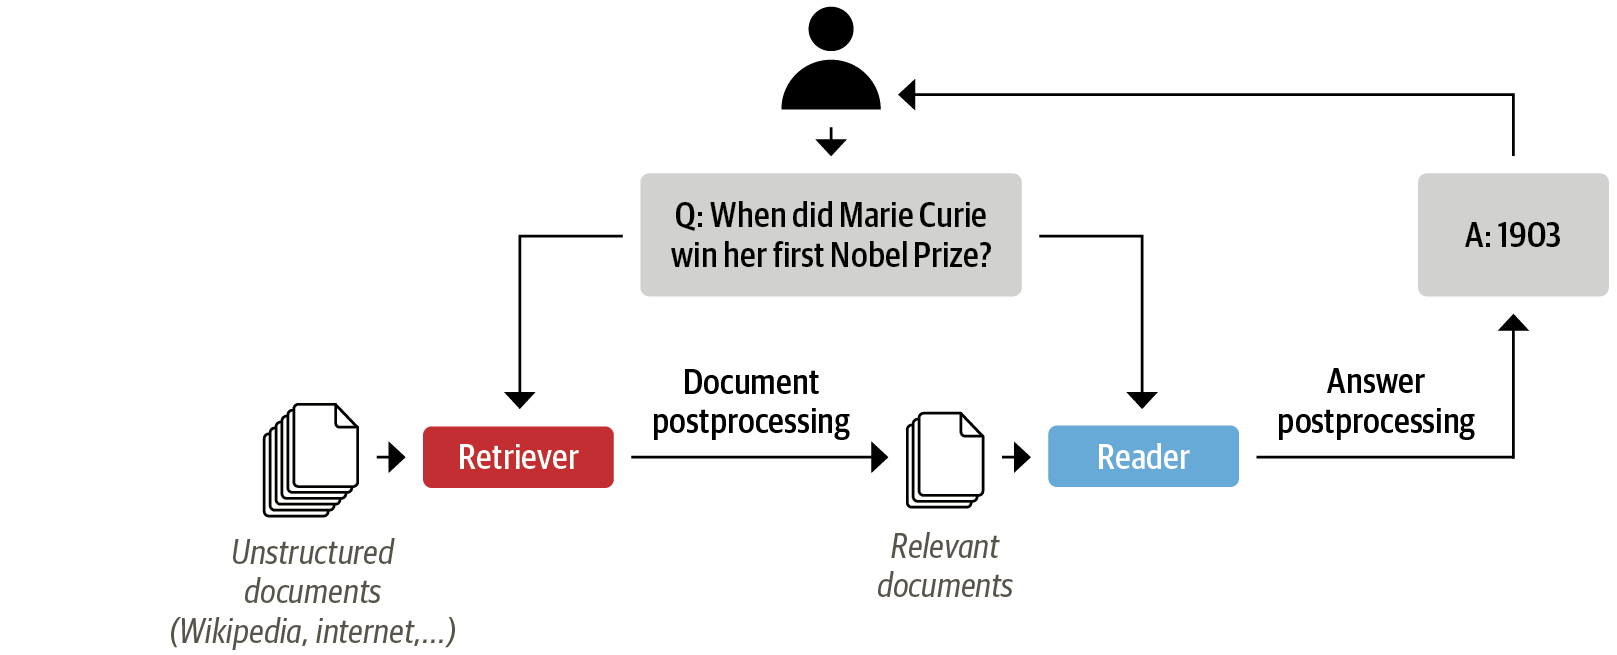

<p style='font-size:17px;font-weight:bold'>
Initializing a document store
</p>

**Compatibility of `Haystack` retrievers and document search**

In [13]:
data = {
    "In memory":["Yes", "No", "Yes", "Yes"],
    "Elasticsearch": ["Yes", "Yes", "Yes", "Yes"],
    "FAISS": ["No", "No", "Yes", "Yes"],
    "Milvus": ["No", "No", "Yes", "Yes"],
}

# Create the DataFrame
df = pd.DataFrame(data)
df.index = ["TF-IDF", "BM25", "Embedding", "DPR"]

def color_cells(val):
    if val == "Yes":
        return 'background-color: green'  
    elif val == "No":
        return 'background-color: red' 
    return ''

# Apply the color function to all cells
styled_df = df.style.map(color_cells)
styled_df

,In memory,Elasticsearch,FAISS,Milvus
TF-IDF,Yes,Yes,No,No
BM25,No,Yes,No,No
Embedding,Yes,Yes,Yes,Yes
DPR,Yes,Yes,Yes,Yes


**Since we’ll be exploring both sparse and dense retrievers in this chapter, we’ll use the
ElasticsearchDocumentStore, which is compatible with both retriever types.**

**Download and Install Elasticsearch**

In [4]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

**Start the Elasticsearch server**

In [5]:
import os
from subprocess import Popen, PIPE, STDOUT
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE,
                  stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

**Test connection to Elasticsearch with an HTTP request to the default port `9200`**

In [6]:
import requests
requests.get('http://localhost:9200/_cluster/health').json()

{'cluster_name': 'elasticsearch',
 'status': 'green',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 0,
 'active_shards': 0,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 0,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 100.0}

In [7]:
from haystack.document_stores import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(return_embedding=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-10-12 11:31:29,352	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [8]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

**Add Data to the DocumentStore**

In [9]:
for split, df in tqdm(dfs.items()):
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"],
                     "question_id": row["id"], 
                     "split": split}} 
            for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

  0%|          | 0/3 [00:00<?, ?it/s]

Loaded 1615 documents


<p style='font-size:17px;font-weight:bold'>
Initializing a retriever
</p>

**The Elasticsearch document store works by default with Haystack's BM25 retriever, an improved version of TF-IDF.**

In [12]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>
    For review-based QA systems, it’s crucial to restrict queries to a single product to avoid irrelevant results. For example, asking about camera quality without a product filter may return unrelated reviews. We can decode <code>ASIN</code> values using online tools like <a style="text-decoration: underline;" href="https://amazon-asin.com/"><code>amazon ASIN</code></a>
to focus our queries.
</p>


In [10]:
item_id = "B0074BW614" # corresponds to one of Amazon’s Fire tablets
query = "Is it good for reading?"

In [13]:
retrieved_docs = bm25_retriever.retrieve(
                 query=query,
                 top_k=3,
                 filters={"item_id":[item_id],
                          "split":["train"]})

retrieved_docs[0].to_dict()

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.',
 'content_type': 'text',
 'score': 0.6857824513476455,
 'meta': {'item_id': 'B0074BW614',
  'question_id': '868e311275e26dbafe5af70774a300f3',
  'split': 'train'},
 'id_hash_keys': ['content'],
 'embedding': None,
 'id': '4a6aa9c7808ebba8d35aeecbcc3c30fe'}

**Try 🤗 QA Pipeline**

In [17]:
retrieved_docs[0].to_dict()

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.',
 'content_type': 'text',
 'score': 0.6857824513476455,
 'meta': {'item_id': 'B0074BW614',
  'question_id': '868e311275e26dbafe5af70774a300f3',
  'split': 'train'},
 'id_hash_keys': ['content'],
 'embedding': None,
 'id': '4a6aa9c7808ebba8d35aeecbcc3c30fe'}

In [18]:
print(f'Query: {query}\n')
pipe(question=query,
     context=retrieved_docs[0].to_dict()['content'],
     top_k=3)

Query: Is it good for reading?



[{'score': 0.20584768056869507,
  'start': 132,
  'end': 164,
  'answer': 'I mainly use it for book reading'},
 {'score': 0.10769987851381302,
  'start': 134,
  'end': 164,
  'answer': 'mainly use it for book reading'},
 {'score': 0.10662283003330231,
  'start': 152,
  'end': 164,
  'answer': 'book reading'}]

<p style='font-size:17px;font-weight:bold'>
Initializing a reader
</p>

In [ ]:
from haystack.nodes import TransformersReader

max_seq_length, doc_stride = 384, 128 # handle long sequences
reader = TransformersReader(model_name_or_path="deepset/minilm-uncased-squad2",
                            use_gpu=True if torch.cuda.is_available() else False,
                            max_seq_len=max_seq_length,
                            doc_stride=doc_stride, 
                            return_no_answers=True)

In [15]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""

In [19]:
from haystack import Document

output = reader.predict(query=question,
               documents=[Document(content=context)],
               top_k=3)
output

{'query': 'How much music can this hold?',
 'answers': [<Answer {'answer': '', 'type': 'extractive', 'score': 0.5165665265438865, 'context': None, 'offsets_in_document': [{'start': 0, 'end': 0}], 'offsets_in_context': [{'start': 0, 'end': 0}], 'document_ids': None, 'meta': {}}>,
  <Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.2651614844799042, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>,
  <Answer {'answer': '1 MB/minute, so about 6000 hours', 'type': 'extractive', 'score': 0.22082969546318054, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 16, 'end': 48}], 'offsets_in_context': [{'start': 16, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}

<p style='font-size:17px;font-weight:bold'>
Putting it all together
</p>

**The `Pipeline` abstraction allows us to combine retrievers, readers, and other components**

In [12]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

**Run a simple example using our question about the Amazon Fire tablet**

In [14]:
n_answers = 3
preds = pipe.run(query=query,
                 params={"Retriever": {"top_k": 3,
                                       "filters":{"item_id": [item_id],
                                                  "split":["train"]}}, 
                         "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    # handle empty answers
    if preds['answers'][idx].context is None:
        continue
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 2: it is great for reading books when no light is available
Review snippet: ...ouse and myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones to really hear it all.Ba...



Answer 3: I mainly use it for book reading
Review snippet: ...rs and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my ph...





## Improving Our QA Pipeline

### Evaluating the Retriever


<p style="background-color:#e6f7ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#d0eefc; 
          border-style:solid;
          border-radius:6px"> 💡 A common metric for evaluating retrievers is <code>recall</code>, which measures the fraction of all relevant documents that are retrieved. In this context, <code>relevant</code> simply means whether the answer is present in a passage of text or not, so
given a set of questions, we can compute recall by counting the number of times an answer appears in the <code>top k</code> documents returned by the retriever.
</p>

<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>Evaluating the retriever is the same as evaluating a <code>DocumentSearchPipeline</code>, which consists only of a single node, a retriever.
</p>


In [17]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [18]:
from haystack import Label, Answer, Document

labels = []
for i, row in tqdm(dfs["test"].iterrows(),total=len(dfs["test"])):
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"],
                answer=Answer(answer=answer),
                origin="gold-label",
                document=Document(content=row["context"],
                                  id=row["review_id"]),
                meta=meta,
                is_correct_answer=True,
                is_correct_document=True,
                no_answer=False,
                filters={"item_id": [meta["item_id"]],
                         "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"],
            answer=Answer(answer=""),
            origin="gold-label",
            document=Document(content=row["context"],
                              id=row["review_id"]),
            meta=meta,
            is_correct_answer=True,
            is_correct_document=True,
            no_answer=True,
            filters={"item_id": [row["title"]],
                     "split":["test"]})  
        labels.append(label)

  0%|          | 0/358 [00:00<?, ?it/s]

**Write the labels to the `DocumentStore`**

In [19]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 455 question-answer pairs


**Peek at one of these labels**

In [20]:
labels[312].to_dict()

{'id': 'd11e9140-079e-45cc-b8e2-67522cee949a',
 'query': 'What is range ?',
 'document': {'id': '0a782dbb59b725a0698f725fdb89309e',
  'content': "Using this as a WAP, and not a router.  While it is advertised to have superior range, I find it pretty average at best.  This is across multiple devices.  Also, I've experienced (with multiple devices) intermittent problems just getting connectivity.  I'm not satisfied enough with it to keep it, and plan to pack it up and return it this weekend.  It just is not that great.  Does it work?  Pretty much.  Do I find it in any way superior?  No way.  Considering the price, it just is not worth it.",
  'content_type': 'text',
  'meta': {},
  'id_hash_keys': ['content'],
  'score': None,
  'embedding': None},
 'is_correct_answer': True,
 'is_correct_document': True,
 'origin': 'gold-label',
 'answer': {'answer': '',
  'type': 'extractive',
  'score': None,
  'context': None,
  'offsets_in_document': None,
  'offsets_in_context': None,
  'document_i

**aggregate all question-answer pairs associated with a unique product ID (ASIN)**

In [21]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"] # ASIN product ID
)
print(len(labels_agg))

330


**Take a look at an example**

In [64]:
labels_agg[312].to_dict()

{'labels': [{'id': '0ea37f11-9268-49ce-992e-386bd5020418',
   'query': 'How is the camera lens is one of worse?',
   'document': {'id': 'fdc3ddc7d78b699f79bcc3035526ac58',
    'content': "The potential for this once pandora and chrome (from Android) casting is available is why I bought it.  I don't use netflix and I use youtube sometimes so reall this is fairly limited at the moment.The ability for it to turn on your TV and swap inputs for you is awesome.  Note that turning the TV on is only possible if the USB power is on while the TV is not (usually will mean external power source) and I believe it requires the latest HDMI standard.  The input switching should work for most everyone.I love that it streams from the net itself so your phone isn't rendering or DLing anything.  Saves my battery while I still get to use it as a remote and browse whatever else I want to while the thing I &#34;cast&#34; is on the TV.Awesome device, awesome price, awesome potential.  Needs more apps to reach

**Let's evaluate the performance of the `retriever` by running the pipeline `eval` method and calculate the recall at $top_k = 3$. It measures how often the correct document is retrieved within the top 3 results.**

In [22]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [23]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.96


**Check the predictions of any query**

In [31]:
query = "How do you like the lens?"

eval_df = eval_result["Retriever"]
cols = ['gold_answers','context','gold_contexts','document_id','gold_document_ids']
eval_df[eval_df["query"] == query][cols]

,gold_answers,context,gold_contexts,document_id,gold_document_ids
3,[I do recommend this lens],I bought this lens for my Canon 20D digital ca...,[I bought this lens for my Canon 20D digital c...,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63]
4,[I do recommend this lens],I am not a professional or expert photographer...,[I bought this lens for my Canon 20D digital c...,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63]
8,[],I think that the title says it all. It is one ...,[],9cae133919a2dc476c371cde9e5effb8,[]
9,[],I bough this lens for a relative who bought my...,[],a1f6e39766a79f1475b3dbe07e517e04,[]
10,[],I fell in love with the lens the moment I star...,[],0fc71a2e4ec350e845ed384717792ad8,[]
133,[than you're used to compared to Nikon or Zeis...,I have read a lot of negative press about this...,[I have read a lot of negative press about thi...,47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62c..."


**We'll evaluate the retriever on k retrieved doculnets and compute the recall across the whole test set for each k**

In [24]:
def evaluate_retriever(retriever,
                       topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in tqdm(topk_values,leave=False):        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")

In [25]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

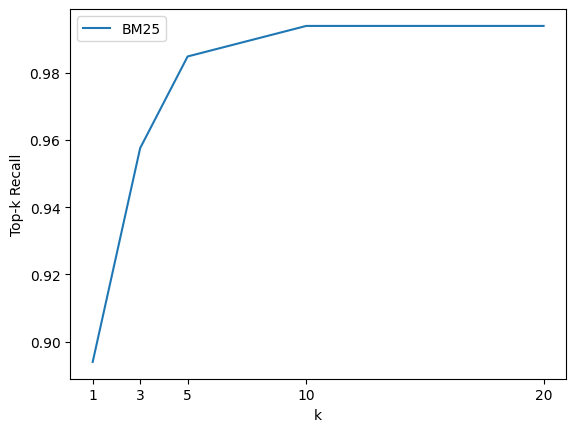

In [35]:
bm25_topk_df = evaluate_retriever(bm25_retriever)
plot_retriever_eval([bm25_topk_df], ["BM25"])

### Dense Passage Retrieval

<p style="background-color:#fff6ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#efe6ef; 
          border-style:solid;
          border-radius:6px"> 🔗 We’ve seen that we get almost perfect recall when our sparse retriever returns <code>k = 10</code> documents, but can we do
better at smaller values of k?<br>. The advantage of doing so is that we can pass fewer documents to the reader and
thereby reduce the overall latency of our QA pipeline. A well-known limitation of sparse retrievers like <code>BM25</code> is
that they can fail to capture the relevant documents if the user query contains terms that don’t match exactly those
of the review. One promising alternative is to use dense embeddings to represent the question and document, and
    the current state of the art is an architecture known as Dense Passage Retrieval <code>(DPR)</code>. The main idea behind
    DPR is to use two <code>BERT</code> models as encoders for the question and the passage. As illustrated in the Figure, these
encoders map the input text into a d-dimensional vector representation of the <code>[CLS] token</code>.
</p>

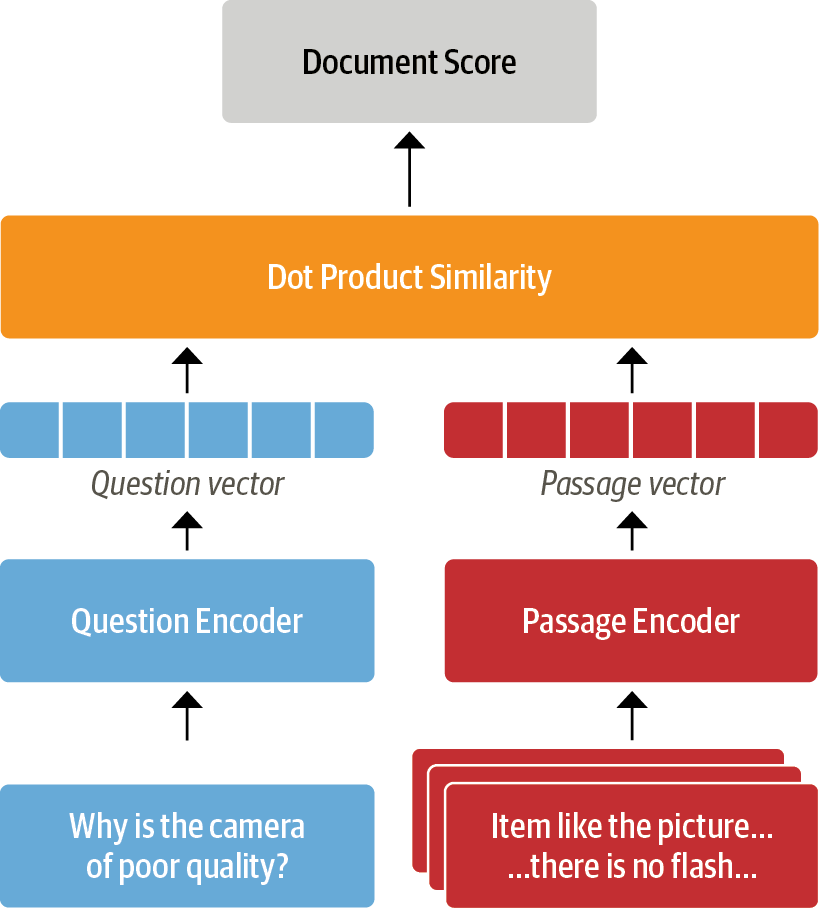

**Here we `set embed_title=False` since concatenating the document’s title (i.e., item_id) doesn’t
provide any additional information because we filter per product**

In [11]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

**Create Embeddings for the documents** 

In [12]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings: 10000 Docs [00:23, 429.14 Docs/s]          


**Evaluate `DPR` Retriever**

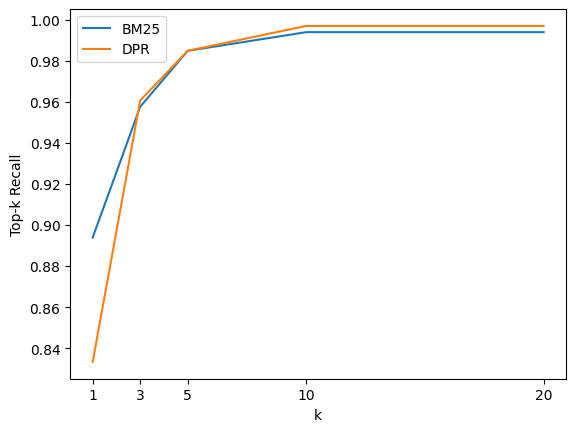

In [39]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Evaluating the Reader

<div style="
    background-color: #f7f7f7;
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #e3e3e3;
    border-style: solid;
    border-radius: 6px;
            ">
    📚  In <code>extractive QA</code>, there are two main metrics that are  used <br> for evaluating readers:
  <ul style="background-color: inherit; /* Use the parent background color */
    color: inherit; /* Use the parent text color */
    font-size: inherit; /* Use the parent font size */
    list-style-type: disc;
    margin-left: 20px;
    padding-left: 0;">
    <li><code>Exact Match (EM)</code>:
            A binary metric that gives EM = 1 if the characters in the   predicted and ground truth answers match exactly,
    and EM = 0 otherwise.
        If no answer is expected, the model gets EM = 0 if it predicts any text at all.
      </li>
    <li><code>F -score</code>: Measures the harmonic mean of the precision and recall.
</li></ul>
</div>

In [27]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

In [19]:
pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8



<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>From this simple example we can see that <code>EM</code> is a much stricter
    metric than the <code>F -score</code>:<br> adding a single token to the prediction gives an EM of zero. On the other hand, the F -
score can fail to catch truly incorrect answers: Here's an example
</p>



In [16]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4



<p style='color:#111;
          background-color:#fff;
          border-radius:4px;
          border-color:#111;
          border-size:2px;
          padding:8px
          '>
Our predicted answer span is <code>about 6000 dollars</code> an incorrect answer, we get an F-score of <code>0.4</code>.<br>
    Relying on just the <code>F -score</code> is thus misleading, and tracking both metrics is a good strategy to balance the tradeoff between underestimating (EM) and overestimating (F -score) model performance.
</p>



In [28]:
from haystack.pipelines import Pipeline

def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

In [29]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

In [30]:
reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

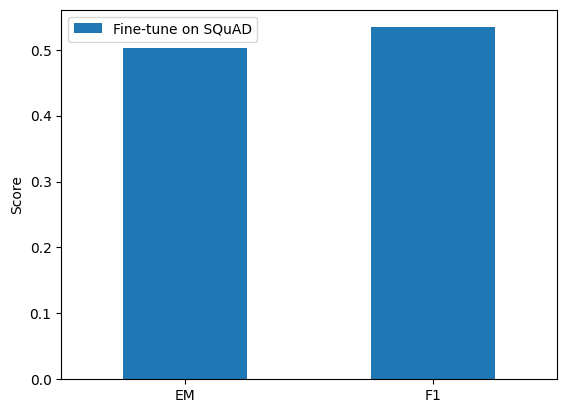

In [31]:
plot_reader_eval(reader_eval)

### Domain Adaptation

<p style="background-color:#e6ffe6; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#d9f5d9; 
          border-style:solid;
          border-radius:6px"> 🔧 Models fine-tuned on <code>SQuAD</code> often struggle to generalize to other domains, as seen with lower <code>EM</code> and <code>F scores</code> on <code>SubjQA</code>. This overfitting issue is common with transformer models. To improve performance, the <code>MiniLM model</code> can be further fine-tuned on the SubjQA training set using the <code>FARMReader’s train()</code> method, which requires data in the <code>SQuAD JSON format</code> as illustrated in the figure.
</p>



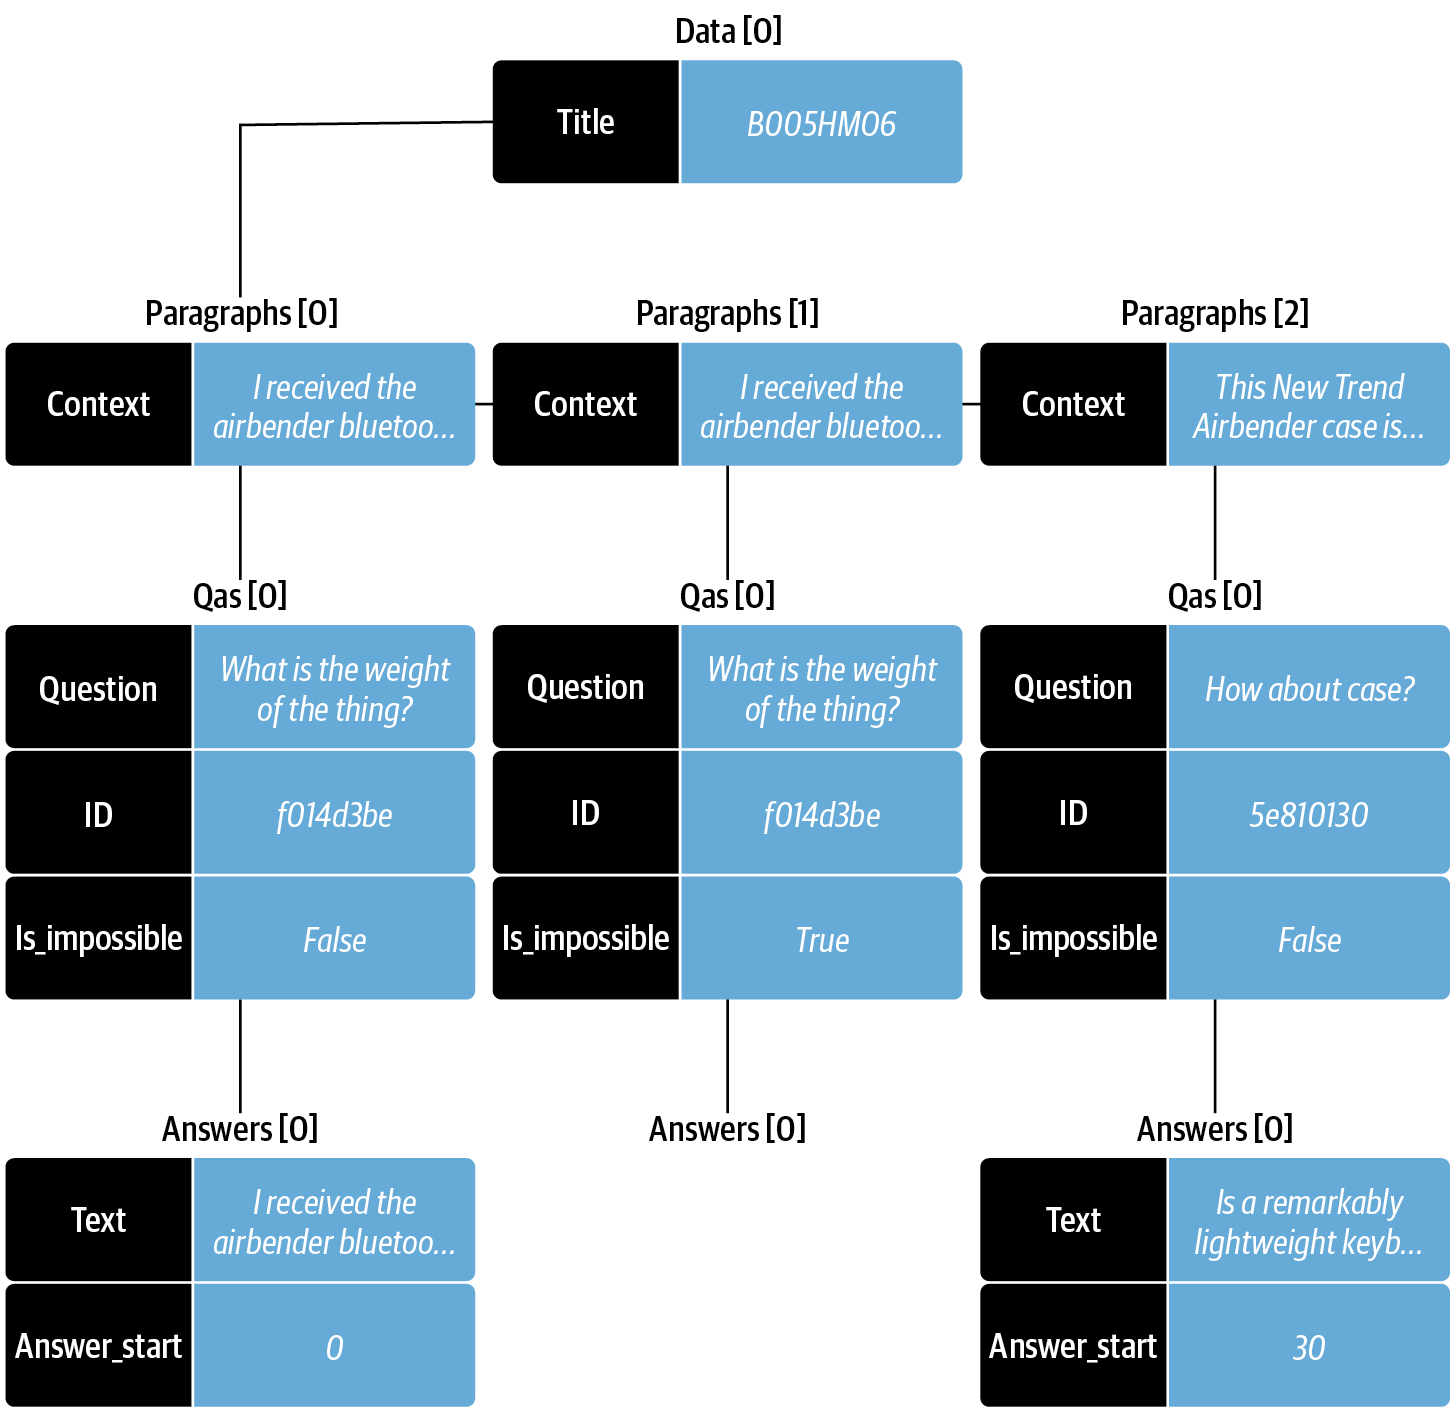

**Creates a paragraphs array for each product ID**

In [9]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

**SQuAD format for a single product ID**

In [10]:
product = dfs["train"].query(f"title == 'B0052SCU8U'") # title -> product ID (ASIN)
create_paragraphs(product)

[{'qas': [{'question': 'How was the price of the product?',
    'id': '58b9acd2460694bb752f9044a63bcaef',
    'is_impossible': False,
    'answers': [{'text': 'very affordable', 'answer_start': 148},
     {'text': 'pay crazy prices for', 'answer_start': 227}]}],
  'context': "I bought this to have a few extras since I seem to never have one when I need it.  These work just as good as any other one with the bonus of being very affordable.  Don't let the big brands scare you into thinking you need to pay crazy prices for hdmi cables.  This is all a digital signal.  It either works or it doesn't work.  There isn't a range of quality in between.  That is kind of why they invented digital signals in the first place."}]

**Apply this function to each product `ID` of each `split`, and stores the result in an `electronics-{split}.json` file**

In [ ]:
import json

def convert_to_squad(dfs):
    for split, df in tqdm(dfs.items(),
                          leave=False,total=len(dfs)):
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
                    .to_frame(name="paragraphs")
                    .reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

**Fine Tune the Reader**

In [ ]:
# train_filename = "electronics-train.json"
# dev_filename = "electronics-validation.json"

# use_gpu = True if torch.cuda.is_available() else False
# reader.train(data_dir=".",
#              use_gpu=use_gpu,
#              n_epochs=1,
#              batch_size=16,
#              train_filename=train_filename,
#              dev_filename=dev_filename)

**Evaluate fine-tuned Reader**

In [ ]:
# The arrow indicates that the model is fine-tuned on SQuAD then on SubjQA
reader_eval["Fine-tune on SQuAD -> SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

### Domain Adaptation V2

In [11]:
# def create_paragraphs(df,title):
#     paragraphs = []
#     id2context = dict(zip(df["review_id"], df["context"]))
#     for review_id, review in id2context.items():
#         # Filter for all question-answer pairs about a specific context
#         review_df = df.query(f"review_id == '{review_id}'")
#         id2question = dict(zip(review_df["id"], review_df["question"]))
#         # Build up the qas array
#         for qid, question in id2question.items():
#             # Filter for a single question ID
#             question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
#             ans_start_idxs = question_df["answers.answer_start"][0].tolist()
#             ans_text = question_df["answers.text"][0].tolist()
#             # Fill answerable questions
#             if len(ans_start_idxs):
#                 answers = [
#                     {"text": text, "answer_start": answer_start}
#                     for text, answer_start in zip(ans_text, ans_start_idxs)]
#                 is_impossible = False
#             else:
#                 answers = []
#                 is_impossible = True
#             # Add question-answer pairs to qas
#             paragraphs.append({"id": qid,
#                                "review_id":review_id,
#                                "title":title,
#                                "context":review,
#                                "question": question,
#                                "answers": answers,
#                                "is_impossible": is_impossible,})
#     return paragraphs

In [12]:
# def convert_to_squad(dfs):
#     subjqa_data = {}
#     for split, df in tqdm(dfs.items(),
#                           leave=False,
#                           desc='splits',
#                           total=len(dfs)):
#         data_list = []
#         # Create `paragraphs` for each product ID
#         groups = df.groupby("title")
#         for grp in tqdm(groups,
#                         desc=split,
#                         leave=False):
#             title,df = grp
#             paragraphs = create_paragraphs(df,title)
#             data_list.extend(paragraphs)
            
#         subjqa_data[split] = data_list
        
#     return subjqa_data
# subjqa_data = convert_to_squad(dfs)

In [ ]:
# splits = list(subjqa_data.keys())
# for split in tqdm(splits,desc='Splits'):
#     data = []

#     for example in tqdm(subjqa_data[split],desc="examples",leave=False):
#         answers = example['answers']

#         if len(answers) == 0:
#             data.append(example)
#             continue
#         # remove duplicates
#         tuples = [tuple(sorted(d.items())) for d in answers]
#         unique_tuples = list(set(tuples))
#         answers = [dict(t) for t in unique_tuples]

#         # remove text contained in another text
#         if len(answers) == 2:
#             dict1,dict2 = answers
#             if dict1['text'] in dict2['text']:
#                 answers = [dict1]
#             elif dict2['text'] in dict1['text']:
#                 answers = [dict2]


#         example['answers'] = [answers[0]]
#         data.append(example)
    
#     subjqa_data[split] = data

### Evaluating the Whole QA Pipeline

<p style="background-color:#ffe6f7; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#f5dce9; 
          border-style:solid;
          border-radius:6px"> 💡 Now that we’ve seen how to evaluate the reader and retriever components individually, let’s tie them together to
measure the overall performance of our pipeline. To do so, we’ll need to augment our retriever <code>pipeline</code> with nodes
    for the <code>reader</code> and its evaluation. We’ve seen that we get almost perfect recall at <code>k = 10</code>, so we can fix this value
and assess the impact this has on the reader’s performance.
</p>




In [32]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(retriever=bm25_retriever,
                            reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

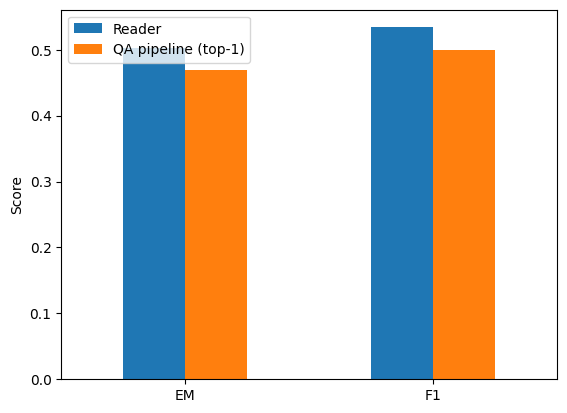

In [36]:
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

$$$$

## Going Beyond Extractive QA


<p style="background-color:#e6f7ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#d0eefc; 
          border-style:solid;
          border-radius:6px"> ✍️ One interesting alternative to extracting answers as spans of text in a document is to generate them. This approach is often referred to as <code>abstractive</code> or <code>generative QA</code> and has the potential
to produce better-phrased answers that synthesize evidence across multiple passages.<br>
Although less mature than
<code>extractive QA</code>, this is a fast-moving field of research,
and we’ll briefly touch on the current state of the art:
retrieval-augmented generation <code>RAG</code>.<br>
<code>RAG</code> extends the classic retriever-reader architecture that we’ve seen in this chapter by swapping the reader for a
generator and using DPR as the retriever.
</p>




In [ ]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

**Example query for Amazon Fire Tablet**

In [4]:
item_id = "B0074BW614" # corresponds to one of Amazon’s Fire tablets
query = "Is it good for reading?"

**Retrieve Docs**

In [54]:
retrieved_docs = dpr_retriever.retrieve(
                 query=query,
                 top_k=3,
                 filters={"item_id":[item_id],
                          "split":["train"]})
context_texts = [doc.content for doc in retrieved_docs]

context_texts[1]

'I love my kindle fire! Colors are crisp and clear, watch movies often, and my grand kids play great games! The price was a plus for me!'

**Generate Answers**

In [93]:
outputs = []
for ctx in tqdm(context_texts):
    input_text = f"Answer the question based on the context:\n question:{query}\n Context: {ctx}"
    inputs = tokenizer(input_text, return_tensors="pt",
                       truncation=True,
                       max_length=512)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    outputs.append(model.generate(**inputs,
                             num_beams=4,
                             num_return_sequences=1,
                             do_sample=True,
                             temperature=0.3,
                             max_length=25).squeeze().cpu())

  0%|          | 0/3 [00:00<?, ?it/s]

In [94]:
print(f"Question: {query} \n")
for idx,output in enumerate(outputs):
    print(f'Answer {idx+1}: {tokenizer.decode(output, skip_special_tokens=True)}')

Question: Is it good for reading? 

Answer 1: The books are beautiful and crisp, too, with plenty of options to change brightness and color. This cuts down on eye
Answer 2: Colors are crisp and clear
Answer 3: It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes


### RAG with an LLM

<p style="background-color:#e6f7ff;
          color:#111;
          font-size:16px;
          padding:15px;
          border-width:3px;
          border-color:#d0eefc;
          border-style:solid;
          border-radius:6px"> 💻 QA can leverage the power of an <code>LLM</code> like <code>GPT3</code> by providing the documents, along with the query and combined into a structured <code>prompt</code> to be fed into the LLM.<br>
The model processes the prompt, synthesizes information from the documents, and generates a coherent answer tailored to the query.
</p>

In [21]:
prompt = f'''
Below are several documents containing reviews related to Amazon electronic products.
Based on these documents, please answer the following question as accurately
and concisely as possible.
Use the information from the documents to form a coherent and detailed response.
Please Provide a short and direct answer that is strictly relevant to the query.
Avoid unnecessary details and focus solely on the key points related to the query.
If no documents are provided, you can say `I cannot answer the query, no docs provided`.
If the answer cannot be determined based on the information in the documents,
please acknowledge that the answer is not available.
'''

In [22]:
prompt += f'\nDocuments:\n'
for i,ctx in enumerate(context_texts):
    prompt += f'{i}. {ctx}\n\n'
prompt += f'\nQuestion:\n'
prompt += f'{query}\n\n'
prompt += f'Answer:\n'

<div style="
    background-color: #fff6ff;
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #efe6ef;
    border-style: solid;
    border-radius: 6px;
            ">
  📚 This is the <code>ChatGPT</code> response given the <code>prompt</code>:
    <br><br>
    <p style="
    background-color: #555;
    color: #fff;
    font-size: 14px;
    padding: 15px;
    border-width: 2px;
    border-color: #111;
    border-style: solid;
    border-radius: 6px;"
        >
֎ &nbsp; &nbsp;Yes, the Kindle Fire is considered <code>good for reading</code>. Users appreciate the crisp and clear colors, which enhance the reading experience, and the device's light weight makes it comfortable to hold. However, some users note that the battery life may not last long and that the screen can glare in bright sunlight. Overall, many find it suitable for reading, though individual comfort may vary, especially for those with physical limitations.</p>
  
</div>


$$$$

## Conculsion

<p style="background-color:#e6f7ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#d0eefc; 
          border-style:solid;
          border-radius:6px">✅ In this project, we explored two approaches to <code>Question Answering</code> (QA): extractive and generative, while also examining retrieval algorithms such as BM25 and DPR and we discussed common metrics for evaluating these systems.<br>
    Although our focus was on closed-domain QA related to electronic products, the techniques are applicable to open-domain scenarios as well.</p>

<p style="background-color:#ffe6f7; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#f5dce9; 
          border-style:solid;
          border-radius:6px"> 🗂️ The <code>hierarchy</code> of needs for tackling QA problems</p>

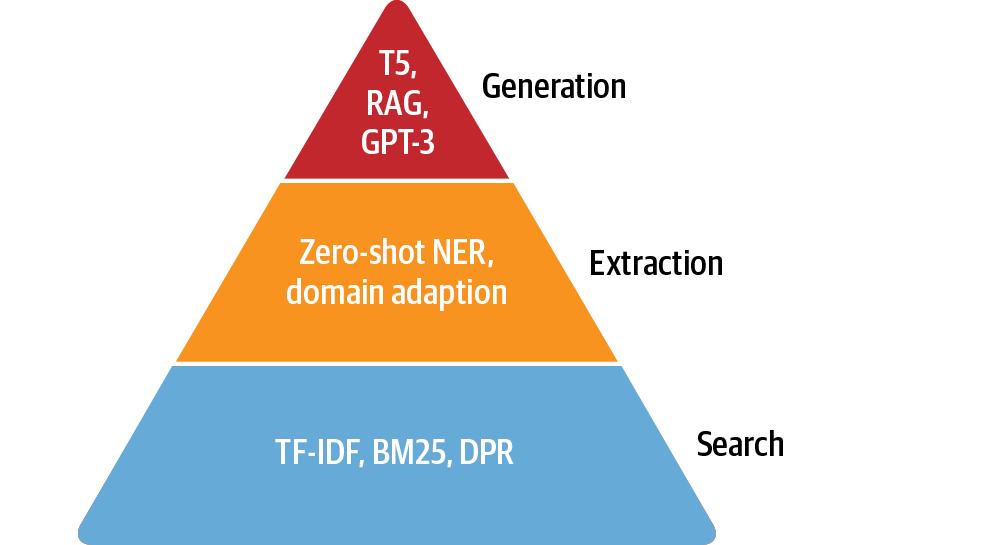
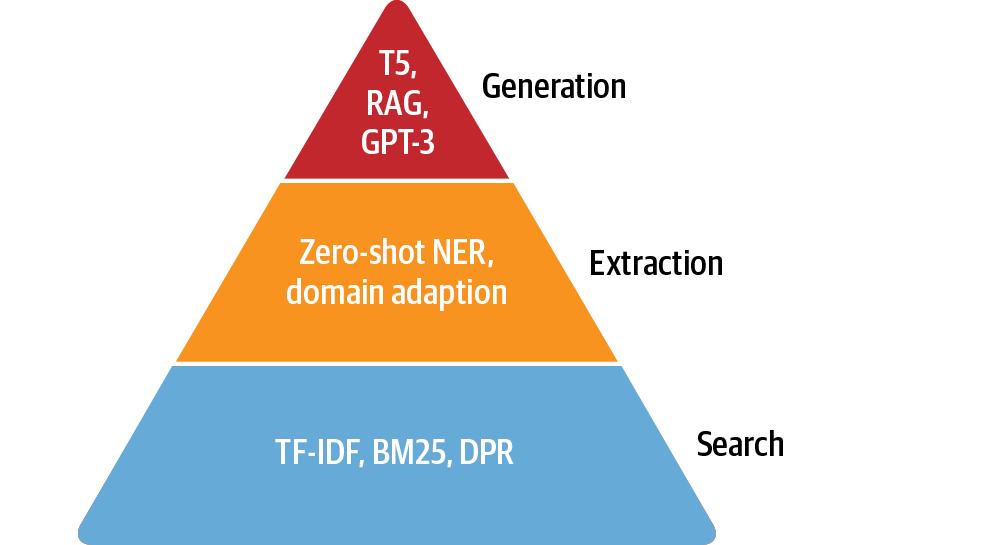

$$$$